### Inits

In [1]:
import sys
sys.path.append("..")

In [2]:
from balls import *


import mpmath
# import pylab
from pylab import *

#Matplotlib defs
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#Numpy
import numpy as np
from numpy.random import multivariate_normal


from scipy import stats
from scipy import stats
import scipy.integrate as integrate
from scipy.interpolate import interp1d as int1d
from scipy.special import erfc as erfc
from scipy.signal import savgol_filter
from scipy.spatial.distance import cdist
from scipy.special import erfcinv as ierfc



import random

import seaborn as sns

from tqdm.notebook import *

import arviz as az

#Astropy
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.coordinates import SkyCoord
from astropy.coordinates import CartesianRepresentation
import astropy.units as u
from astropy.io import fits
from astropy import constants as const

#GetDist
from getdist import plots, MCSamples
import getdist

In [3]:
## balls Try
rtest=np.loadtxt('../checks/rtest.csv',delimiter=',')
Dtest=np.loadtxt('../checks/Dtest.csv',delimiter=',')
DDtest=np.loadtxt('../checks/DDtest.csv',delimiter=',')
at,bt=co_vol_23(1,rtest,Dtest,DDtest)
np.sum(bt)/vol_1(1),np.sqrt(2*np.sum(at)/vol_1(1)+np.sum(bt)/vol_1(1)-(np.sum(bt)/vol_1(1))**2)

(3.8617722683127633, 1.5477916719407956)

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Data Read

In [5]:
hdul = fits.open('../data/DR7.fits')
data = hdul[1].data  # First extension is the table!
ra = data['RA']
dec = data['DEC']
z = data['REDSHIFT']
mass = data['LOGBH']
dmass = data['LOGBH_ERR']


#define restricted parameters and indicators
m_min=7.9
m_max=13
z_max=2.5
z_min=0.4
ra_min=120
ra_max=240
dec_min=0
dec_max=60
DC_all=cosmo.comoving_distance(z)

# QSO_coord = SkyCoord(ra_new*u.degree, dec_new*u.degree, frame='icrs', distance = DC_new)



# # Duty-cycle digitized
# lam06=np.loadtxt(open('../../digi/lam06.csv'), delimiter=",")
# lam03=np.loadtxt(open('../../digi/lam03.csv'), delimiter=",")
# minL=np.loadtxt(open('../../digi/minL.csv'), delimiter=",")
# lam03=np.vstack((lam03,[lam03[-1,0]+5,lam03[-1,1]]))
# lam06=np.vstack((lam06,[lam06[-1,0]+5,lam06[-1,1]]))
# minL=np.vstack((minL,[minL[-1,0]+5,minL[-1,1]]))
# intlam06=int1d(lam06[:,0]-0.02,10**lam06[:,1],kind=1)
# intlam03=int1d(lam03[:,0]-0.01,10**lam03[:,1],kind=1)
# intminL=int1d(minL[:,0],10**minL[:,1],kind=1)

# lamlis=intminL(mass_new)
# lamlis=intlam06(mass_new)

In [6]:
#Make cartsian
def Rvec(r,q,f):
    X=r*np.sin(q)*np.cos(f)
    Y=r*np.sin(q)*np.sin(f)
    Z=r*np.cos(q)
    return np.transpose(np.array([X,Y,Z]))





# QSO_car=Rvec(DC_new.value,dec_new*np.pi/180,ra_new*np.pi/180)
QSO_car=Rvec(DC_all,dec*np.pi/180,ra*np.pi/180)#[(z>z_min) & (z<z_max)]

In [7]:
obs_ball=4079.8773994784547* np.array([[-0.535438571301582, 0, 0.8445741745770591]])#(cosmo.comoving_distance(z_max)-cosmo.comoving_distance(z_min)).value/2*np.array([[-np.sin(60*np.pi/180),0,np.cos(60*np.pi/180)]])
# obs_ball2=(cosmo.comoving_distance(z_max)-cosmo.comoving_distance(z_min)).value/2*np.array([[-np.sin(30*np.pi/180),0,np.cos(30*np.pi/180)]])

In [8]:
z_at_value(cosmo.comoving_distance,4079.8773994784547*u.Mpc),np.arctan2(0.535438571301582,0.8445741745770591)*180/np.pi

(1.299229222239744, 32.3736591270387)

In [9]:
QO_dsit=(cdist(obs_ball,QSO_car).flatten())

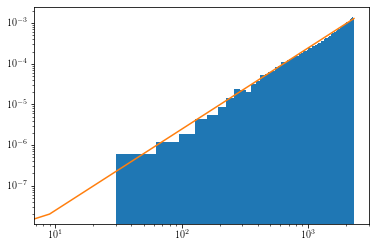

In [10]:
# Here we show that we have a uniform dist 
rm=2300
zm=z_at_value(cosmo.comoving_distance,rm*u.Mpc)
zlis=np.linspace(0,zm,300)
xlis=cosmo.comoving_distance(zlis)
ylis=4*np.pi*cosmo.comoving_distance(zlis)**2/cosmo.comoving_volume(zm)

# plt.hist(QO_dsit2[QO_dsit2<rm],bins=50)
plt.hist(QO_dsit[QO_dsit<rm],bins=70,density=1)

plt.plot(xlis,3*xlis**2/rm**3)
plt.yscale('log')
plt.xscale('log')
# plt.plot(xlis,3*ylis2)
plt.show()

In [11]:
len(QSO_car[QO_dsit<2300]), vol_1(2300)/10**10,(vol_1(2300)/(vol_1(1)*len(QSO_car[QO_dsit<2300])))**(1/3)

(50632, 5.0965010421636014, 62.17075504789603)

In [12]:
m_min=8
m_max=12
z_max=2.5
z_min=0.4

inds=(mass<m_max) & (mass>m_min) & (z < z_max) & (z > z_min) & (QO_dsit<2300)

# restricted arrays
z_new=z[inds]
dec_new=dec[inds]
ra_new=ra[inds]
mass_new=mass[inds]
dmass_new=dmass[inds]
QO_new=QO_dsit[inds]

QSO_car_new=QSO_car[inds]


DC_new=cosmo.comoving_distance(z_new)
DA_new=cosmo.angular_diameter_distance(z_new)

QO_dsit=(cdist(obs_ball,QSO_car_new).flatten())
QQ_dsit=cdist(QSO_car_new,QSO_car_new)

In [13]:
z_at_value(cosmo.comoving_volume,np.mean(cosmo.comoving_volume(z_new)))

1.3631655084573324

### Functions and constants

In [14]:
theta_BH_const=(5*const.G*const.M_sun*u.rad/(const.c)**2).to(u.microarcsecond*u.Mpc)
def theta_BH(logM,DA):
    return theta_BH_const*10**logM/DA


# M_sig relation from Ho & Kormendy 2013 in units of km/sec
def MBH_to_sig(logM):
    return (10**(logM-9)/0.31)**(1/4.38)*200

grav_BH_const=(const.G*const.M_sun*u.rad/(u.km/u.s)**2).to(u.arcsecond*u.Mpc)
def grav_BH(logM,DA):
    return grav_BH_const*10**logM/DA/(MBH_to_sig(logM))**2

#Co-moving to Angular Diameter distance
cmd_to_add=int1d(logspace(-2,4.1,200),cosmo.angular_diameter_distance(np.array([z_at_value(cosmo.comoving_distance,x*u.Mpc) for x in logspace(-2,4.1,200)])).value)

In [15]:
lis=np.linspace(0,4,1000)
DA_max=np.max(cosmo.angular_diameter_distance(lis)).value #Mpc
lis=lis[:np.argmax(cosmo.angular_diameter_distance(lis))]
DAt_lis=cosmo.angular_diameter_distance(lis).value
DCt_lis=cosmo.comoving_distance(lis)
DCt_lis=np.append(DCt_lis,cosmo.comoving_distance(lis[-1])).value
DAt_lis=np.append(DAt_lis,DA_max)
add_to_cmd=int1d(DAt_lis,DCt_lis)


In [16]:
z_at_value(cosmo.comoving_distance,1300*u.Mpc)

0.3181231629760229

In [17]:
#Calculate the mean number of BH seen in a mass bin for different max distance 
mass_logs=np.linspace(7.9,12,30)
robs=1000
r1=400
r2=700
r3=1300

volvol=vol_1(robs)
Nmassr1=np.zeros(len(mass_logs))
Smassr1=np.zeros(len(mass_logs))
Nmassr2=np.zeros(len(mass_logs))
Smassr2=np.zeros(len(mass_logs))
Nmassr3=np.zeros(len(mass_logs))
Smassr3=np.zeros(len(mass_logs))
    

    
for i,x in enumerate(tqdm(mass_logs[:-1])):
#     indst=(QO_new<robs+r1) & (mass_new>x) & (mass_new<mass_logs[i+1])
#     QOt=QO_new[indst]
#     QQt=cdist(QSO_car_new[indst],QSO_car_new[indst])
    
#     a3t,a2t=co_vol_23(robs,0*QOt+r1,QOt,QQt)
#     Nmassr1[i],Smassr1[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)
    
    
    
#     indst=(QO_new<robs+r2) & (mass_new>x) & (mass_new<mass_logs[i+1])
#     QOt=QO_new[indst]
#     QQt=cdist(QSO_car_new[indst],QSO_car_new[indst])
    
#     a3t,a2t=co_vol_23(robs,0*QOt+r2,QOt,QQt)
#     Nmassr2[i],Smassr2[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)
    
    
    indst=(QO_new<robs+r3) & (mass_new>x) & (mass_new<mass_logs[i+1])
    QOt=QO_new[indst]
    QQt=cdist(QSO_car_new[indst],QSO_car_new[indst])
    
    
    a3t,a2t=co_vol_23(robs,0*QOt+r3,QOt,QQt)
    Nmassr3[i],Smassr3[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)

# Here we show that basically all distances gives the same QSO-MF

plt.loglog(10**mass_logs,Nmassr1/vol_1(r1))
plt.fill_between(10**mass_logs,(Nmassr1+Smassr1)/vol_1(r1),(Nmassr1-Smassr1)/vol_1(r1),alpha=0.2)

plt.loglog(10**mass_logs,Nmassr2/vol_1(r2))
plt.fill_between(10**mass_logs,(Nmassr2+Smassr2)/vol_1(r2),(Nmassr2-Smassr2)/vol_1(r2),alpha=0.2)

plt.loglog(10**mass_logs,Nmassr3/vol_1(r3))
plt.fill_between(10**mass_logs,(Nmassr3+Smassr3)/vol_1(r3),(Nmassr3-Smassr3)/vol_1(r3),alpha=0.2)


plt.show()

In [18]:
# Find R_i for a given mass

# Fake D_A*theta[muas] list (i.e. it may be larger than D_A max)
 
def Ri_theta(theta,Rmax,fDA):
    DA_temp=fDA/theta # divide by theta to get the fake DA
    bol_temp=DA_temp>=DA_max # where is it larger than DA_max?
    DA_temp[bol_temp]=np.full(np.sum(bol_temp),DA_max) # replace the ones larger than DA_max by DA_max
    DC_temp=add_to_cmd(DA_temp) # convert DA-->DC
    bol_temp=DC_temp>Rmax # find which ones are larger than Rmax
    DC_temp[bol_temp]=np.full(np.sum(bol_temp),Rmax) # replace the ones larger than R_max by R_max
    return DC_temp

In [19]:
#mass function +- std
n3=2*10**3*Nmassr3/vol_1(r3)/(np.diff(mass_logs)[0])
dn3=2*10**3*(Smassr3)/vol_1(r3)/(np.diff(mass_logs)[0])
n3p=2*10**3*(Nmassr3+Smassr3)/vol_1(r3)/(np.diff(mass_logs)[0])
n3m=2*10**3*(Nmassr3-Smassr3)/vol_1(r3)/(np.diff(mass_logs)[0])

ii=n3>0

sn3=10**savgol_filter(np.log10(n3[ii]),7,3)
dsn3=10**savgol_filter(np.log10(dn3[ii]),7,3)

insn=int1d(mass_logs[ii],sn3,kind=3)
insdn=int1d(mass_logs[ii],dsn3,kind=3)

fine_mass=np.linspace(8,10.5,300)

n_BH=insn(fine_mass)
dn_BH=insdn(fine_mass)


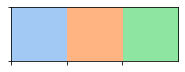

In [20]:
lis=["Accent", "Accent_r", "Blues", "Blues_r", "BrBG", "BrBG_r", "BuGn", "BuGn_r", "BuPu", "BuPu_r", "CMRmap", "CMRmap_r", "Dark2", "Dark2_r", 
     "GnBu", "GnBu_r", "Greens", "Greens_r", "Greys", "Greys_r", "OrRd", "OrRd_r", "Oranges", "Oranges_r", "PRGn",
     "PRGn_r", "Paired", "Paired_r", "Pastel1", "Pastel1_r", "Pastel2", "Pastel2_r", "PiYG", "PiYG_r", "PuBu", "PuBuGn", 
     "PuBuGn_r", "PuBu_r", "PuOr", "PuOr_r", "PuRd", "PuRd_r", "Purples", "Purples_r", "RdBu", "RdBu_r", "RdGy", "RdGy_r", "RdPu", "RdPu_r", 
     "RdYlBu", "RdYlBu_r", "RdYlGn", "RdYlGn_r", "Reds", "Reds_r", "Set1", "Set1_r", "Set2", "Set2_r", "Set3", "Set3_r", "Spectral", "Spectral_r", "Wistia",
     "Wistia_r", "YlGn", "YlGnBu", "YlGnBu_r", "YlGn_r", "YlOrBr", "YlOrBr_r", "YlOrRd", "YlOrRd_r", "afmhot", "afmhot_r", "autumn", "autumn_r", "binary", 
     "binary_r", "bone", "bone_r", "brg", "brg_r", "bwr", "bwr_r", "cet_gray", "cet_gray_r", "cividis", "cividis_r", "cool", "cool_r", "coolwarm", "coolwarm_r", 
     "copper", "copper_r", "cubehelix", "cubehelix_r", "flag", "flag_r", "gist_earth", "gist_earth_r", "gist_gray", "gist_gray_r", "gist_heat", 
     "gist_heat_r", "gist_ncar", "gist_ncar_r", "gist_rainbow", "gist_rainbow_r", "gist_stern", "gist_stern_r", "gist_yarg", "gist_yarg_r", "gnuplot", "gnuplot2",
     "gnuplot2_r", "gnuplot_r", "gray", "gray_r", "hot", "hot_r", "hsv", "hsv_r", "icefire", "icefire_r", "inferno", "inferno_r", "jet", "jet_r", "magma", 
     "magma_r", "mako", "mako_r", "nipy_spectral", "nipy_spectral_r", "ocean", "ocean_r", "pink", "pink_r", "plasma", "plasma_r", "prism", "prism_r", 
     "rainbow", "rainbow_r", "rocket", "rocket_r", "seismic", "seismic_r", "spring", "spring_r", "summer", "summer_r", "tab10", "tab10_r", "tab20", "tab20_r", 
     "tab20b", "tab20b_r", "tab20c", "tab20c_r", "terrain", "terrain_r", "twilight", "twilight_r", "twilight_shifted", "twilight_shifted_r", "viridis", "viridis_r",
     "vlag", "vlag_r", "winter", "winter_r"]
# for x in lis:
#     sns.palplot(sns.color_palette(x,n_colors=9))
sns.palplot(sns.color_palette("pastel",n_colors=3))

[2, 3, 4]

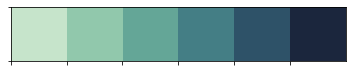

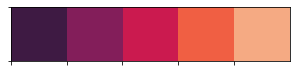

In [21]:
sns.palplot(sns.cubehelix_palette(rot=-.4))
sns.palplot(sns.color_palette("rocket",n_colors=5))
[0,1,2,3,4][2:]

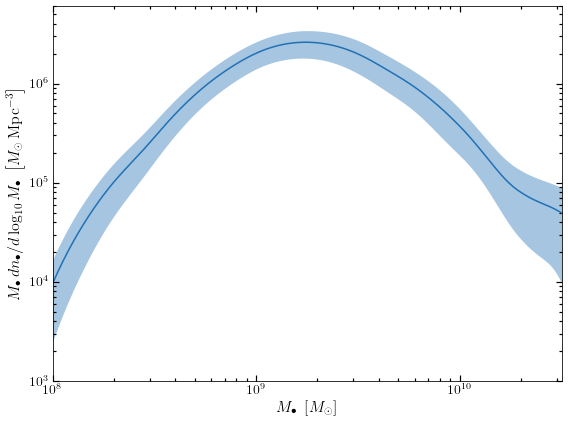

In [23]:
# colis=[[0.555556, 0.555556, 1.], [0.586667, 0.666667, 0.586667], [1., 0.5, 
#   0.5]]
# colis=np.flip(sns.color_palette("GnBu",n_colors=9),axis=0)
# colis=(sns.color_palette("cividis",n_colors=3))
colis=(sns.color_palette("Blues",n_colors=3))

colis5b=(sns.color_palette("Blues",n_colors=5))
colis5p=(sns.color_palette("Purples",n_colors=5))

colis2=(sns.color_palette("Purples",n_colors=3))
# colis=np.flip(['#fac05e','#3fa7d6','#59cd90'])
# colis=sns.cubehelix_palette(rot=-.4)[1:5]

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(10**fine_mass,10**fine_mass*n_BH,c=colis[2])
a=ax.fill_between(10**fine_mass,10**fine_mass*(n_BH+dn_BH),10**fine_mass*(n_BH-dn_BH),linewidth=0,facecolor=colis[2], alpha=0.4)
a.set_edgecolor("face")


plt.ylabel(r'${M_\bullet\,dn_\bullet/d\log_{10} M_\bullet}\;\left[M_\odot\,\rm Mpc^{-3}\right]$', fontsize=16)
plt.xlabel(r'$M_\bullet\;\left[M_\odot\right]$', fontsize=16)




ax.tick_params(axis='both', which='both', direction='in', top=True,right=True, labelsize=14)

ax.tick_params(axis='both', which='major', length=6,width=1.2)
ax.tick_params(axis='both', which='minor', length=3,width=1.2)

# ax.legend(loc='upper right',fontsize=10) 
plt.xlim(10**8,10**10.5)
plt.ylim(1000,6*10**6)

plt.savefig('../figs/BHS/MF.pdf')

plt.show()

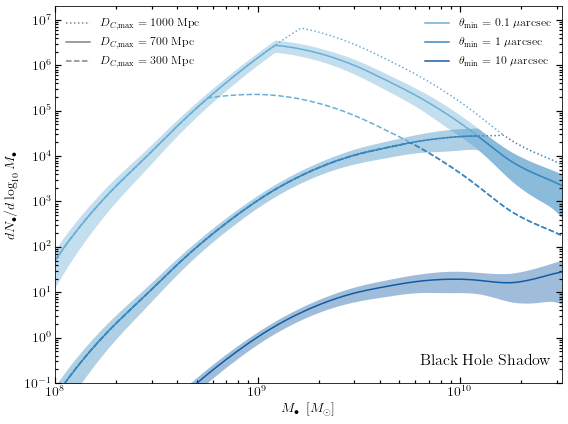

In [24]:
# shadow
fake_DA_theta=theta_BH(fine_mass,u.Mpc)/u.microarcsecond
vol_m_300_p1=vol_1(Ri_theta(.1,300,fake_DA_theta))
vol_m_300_1=vol_1(Ri_theta(1,300,fake_DA_theta))

vol_m_1000_p1=vol_1(Ri_theta(.1,1000,fake_DA_theta))
vol_m_1000_1=vol_1(Ri_theta(1,1000,fake_DA_theta))

vol_m_p1=vol_1(Ri_theta(0.1,700,fake_DA_theta))
vol_m_1=vol_1(Ri_theta(1,700,fake_DA_theta))
vol_m_10=vol_1(Ri_theta(10,700,fake_DA_theta))



fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

# ax.loglog(10**fine_mass,vol_m_1000*n_BH,ls='--')
# plt.fill_between(10**fine_mass,vol_m_1000*(n_BH+dn_BH),vol_m_1000*(n_BH-dn_BH),alpha=0)
# ax.loglog(10**fine_mass,vol_m_300*n_BH,ls=':')
# plt.fill_between(10**fine_mass,vol_m_300*(n_BH+dn_BH),vol_m_300*(n_BH-dn_BH),alpha=0)




ax.loglog(10**fine_mass,vol_m_p1*n_BH,color=colis5b[-3],label=r'$\theta_{\rm min}=0.1\;\mu\rm arcsec$')
plt.fill_between(10**fine_mass,vol_m_p1*(n_BH+dn_BH),vol_m_p1*(n_BH-dn_BH),color=colis5b[-3],linewidth=0,alpha=0.4
                 )

ax.loglog(10**fine_mass,vol_m_1*n_BH,color=colis5b[-2],label=r'$\theta_{\rm min}=1\;\mu\rm arcsec$')
plt.fill_between(10**fine_mass,vol_m_1*(n_BH+dn_BH),vol_m_1*(n_BH-dn_BH),color=colis5b[-2],linewidth=0,alpha=0.4
                )

plt.loglog(10**fine_mass,vol_m_10*n_BH,color=colis5b[-1],label=r'$\theta_{\rm min}=10\;\mu\rm arcsec$')
plt.fill_between(10**fine_mass,vol_m_10*(n_BH+dn_BH),vol_m_10*(n_BH-dn_BH),color=colis5b[-1],linewidth=0,alpha=0.4
                )


ax.loglog(10**fine_mass[fine_mass<np.log10(5.65)+9],(vol_m_300_p1*n_BH)[fine_mass<np.log10(5.65)+9],color=colis5b[-3],ls='--')
ax.loglog(10**fine_mass[fine_mass<np.log10(1.65)+10],(vol_m_1000_p1*n_BH)[fine_mass<np.log10(1.65)+10],color=colis5b[-3],ls=':')
ax.loglog(10**fine_mass,vol_m_300_1*n_BH,color=colis5b[-2],ls='--')
ax.loglog(10**fine_mass,vol_m_1000_1*n_BH,color=colis5b[-2],ls=':')

ax.loglog(10**fine_mass,vol_m_300_1*n_BH,color=colis5b[-2],ls='--')

D1,=ax.plot(10**fine_mass,vol_m_1000_1*n_BH*10**(-12),color='gray',ls=':')#,label=r'$D_{C,\rm max}=1000\;\rm Mpc$')
D2,=ax.plot(10**fine_mass,vol_m_300_1*n_BH*10**(-12),color='gray')#,label=r'$D_{C,\rm max}=300\;\rm Mpc$')
D3,=ax.plot(10**fine_mass,vol_m_300_1*n_BH*10**(-12),color='gray',ls='--')#,label=r'$D_{C,\rm max}=300\;\rm Mpc$')




plt.xlim(10**8,10**10.5)
plt.ylim(.1,10**7.3)

leg1=ax.legend(loc='upper right',fontsize=12,frameon=False) 
leg2=ax.legend([D1,D2,D3],[r'$D_{C,\rm max}=1000\;\rm Mpc$',r'$D_{C,\rm max}=700\;\rm Mpc$',r'$D_{C,\rm max}=300\;\rm Mpc$'],loc='upper left',fontsize=12,frameon=False) 
ax.add_artist(leg1)

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True, labelsize=14)

ax.tick_params(axis='both', which='major', length=6,width=1.2)
ax.tick_params(axis='both', which='minor', length=3,width=1.2)

plt.text(10**9.8,10**-.6,r'${\rm Black\;Hole\;Shadow}$', fontsize=16)
#plt.title(r'${\rm Gravitational\;Influence.}\;\;\;\;10^8\;M_\odot<M_{\rm QSO}$', fontsize=16)
plt.ylabel(r'${dN_\bullet/d\log_{10} M_\bullet}$', fontsize=14)
plt.xlabel(r'$M_\bullet\;\left[M_\odot\right]$', fontsize=14)

plt.savefig('../figs/BHS/shad_MF.pdf')

plt.show()

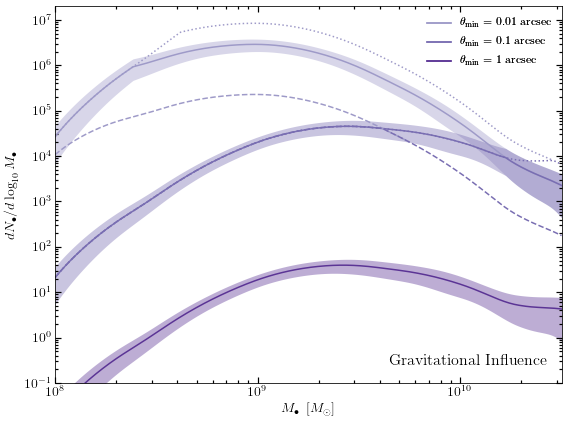

In [25]:
# grav
fake_DA_g=grav_BH(fine_mass,u.Mpc)/u.arcsec
vol_m_300_pp1=vol_1(Ri_theta(.01,300,fake_DA_g))
vol_m_300_p1=vol_1(Ri_theta(.1,300,fake_DA_g))

vol_m_1000_pp1=vol_1(Ri_theta(.01,1000,fake_DA_g))
vol_m_1000_p1=vol_1(Ri_theta(.1,1000,fake_DA_g))

vol_m_pp1=vol_1(Ri_theta(0.01,700,fake_DA_g))
vol_m_p1=vol_1(Ri_theta(.1,700,fake_DA_g))
vol_m_1=vol_1(Ri_theta(1,700,fake_DA_g))

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

# ax.loglog(10**fine_mass,vol_m_1000*n_BH,ls='--')
# plt.fill_between(10**fine_mass,vol_m_1000*(n_BH+dn_BH),vol_m_1000*(n_BH-dn_BH),alpha=0)
# ax.loglog(10**fine_mass,vol_m_300*n_BH,ls=':')
# plt.fill_between(10**fine_mass,vol_m_300*(n_BH+dn_BH),vol_m_300*(n_BH-dn_BH),alpha=0)




ax.loglog(10**fine_mass,vol_m_pp1*n_BH,color=colis5p[-3],label=r'$\theta_{\rm min}=0.01\;\rm arcsec$')
plt.fill_between(10**fine_mass,vol_m_pp1*(n_BH+dn_BH),vol_m_pp1*(n_BH-dn_BH),color=colis5p[-3],linewidth=0,alpha=0.4
                 )

ax.loglog(10**fine_mass,vol_m_p1*n_BH,color=colis5p[-2],label=r'$\theta_{\rm min}=0.1\;\rm arcsec$')
plt.fill_between(10**fine_mass,vol_m_p1*(n_BH+dn_BH),vol_m_p1*(n_BH-dn_BH),color=colis5p[-2],linewidth=0,alpha=0.4
                )

plt.loglog(10**fine_mass,vol_m_1*n_BH,color=colis5p[-1],label=r'$\theta_{\rm min}=1\;\rm arcsec$')
plt.fill_between(10**fine_mass,vol_m_1*(n_BH+dn_BH),vol_m_1*(n_BH-dn_BH),color=colis5p[-1],linewidth=0,alpha=0.4
                )


ax.loglog(10**fine_mass[fine_mass<np.log10(5.65)+9],(vol_m_300_pp1*n_BH)[fine_mass<np.log10(5.65)+9],color=colis5p[-3],ls='--')
ax.loglog(10**fine_mass[fine_mass<np.log10(2.9)+10],(vol_m_1000_pp1*n_BH)[fine_mass<np.log10(2.9)+10],color=colis5p[-3],ls=':')
ax.loglog(10**fine_mass,vol_m_300_p1*n_BH,color=colis5p[-2],ls='--')
ax.loglog(10**fine_mass,vol_m_1000_p1*n_BH,color=colis5p[-2],ls=':')

D1,=ax.plot(10**fine_mass,vol_m_1000_1*n_BH*10**(-12),color='gray',ls=':')#,label=r'$D_{C,\rm max}=1000\;\rm Mpc$')
D2,=ax.plot(10**fine_mass,vol_m_300_1*n_BH*10**(-12),color='gray')#,label=r'$D_{C,\rm max}=300\;\rm Mpc$')
D3,=ax.plot(10**fine_mass,vol_m_300_1*n_BH*10**(-12),color='gray',ls='--')#,label=r'$D_{C,\rm max}=300\;\rm Mpc$')






plt.xlim(10**8,10**10.5)
plt.ylim(.1,10**7.3)

leg1=ax.legend(loc='upper right',fontsize=12,frameon=False) 
#leg2=ax.legend([D1,D2,D3],[r'$D_{C,\rm max}=1000\;\rm Mpc$',r'$D_{C,\rm max}=700\;\rm Mpc$',r'$D_{C,\rm max}=300\;\rm Mpc$'],loc='lower right',fontsize=14,frameon=False) 
ax.add_artist(leg1)

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True, labelsize=14)

ax.tick_params(axis='both', which='major', length=6,width=1.2)
ax.tick_params(axis='both', which='minor', length=3,width=1.2)

plt.text(10**9.65,10**-.6,r'${\rm Gravitational\;Influence}$', fontsize=16)
#plt.title(r'${\rm Gravitational\;Influence.}\;\;\;\;10^8\;M_\odot<M_{\rm QSO}$', fontsize=16)
plt.ylabel(r'${dN_\bullet/d\log_{10} M_\bullet}$', fontsize=14)
plt.xlabel(r'$M_\bullet\;\left[M_\odot\right]$', fontsize=14)

plt.savefig('../figs/BHS/grav_MF.pdf')

plt.show()

In [26]:
# min mass for a given theta
z_rmax=z_at_value(cosmo.comoving_distance,r3*u.Mpc)
zran=np.logspace(-4,np.log10(z_rmax),300)

DC_ran=cosmo.comoving_distance(zran).value



def mmin_z(theta):
    return theta*u.microarcsecond/theta_BH(0,cosmo.angular_diameter_distance(zran))

def mmin_g_z(theta):
    return (theta*u.arcsecond/grav_BH(0,cosmo.angular_diameter_distance(zran)))**(1/0.543379)#power-law from the M-sig relation


In [27]:
#Shadow
# Number per comoving dist
def dN_shad_dDC(q):
    thing=np.array([
        4*np.pi*DC_ran[i]**2*np.trapz(n_BH[fine_mass>x],fine_mass[fine_mass>x]) 
        for i,x in enumerate(np.log10(mmin_z(q).value))
    ])
    return thing
#and the error
def ddN_shad_dDC(q):
    thing=np.array([
        4*np.pi*DC_ran[i]**2*np.trapz(dn_BH[fine_mass>x],fine_mass[fine_mass>x]) 
        for i,x in enumerate(np.log10(mmin_z(q).value))
    ])
    return thing+dN_shad_dDC(q),-thing+dN_shad_dDC(q)


# total for theta min and DC max
theta_logs=np.logspace(-2,2,50)

def N_shad_q(DCmax):
    thing=np.array([
        np.trapz(dN_shad_dDC(q)[DC_ran<=DCmax*1.001],DC_ran[DC_ran<=DCmax*1.001])
        for q in theta_logs
    ])
    return thing
# and error
def dN_shad_q(DCmax):
    thing0=np.array([
        np.trapz(ddN_shad_dDC(q)[0][DC_ran<=DCmax*1.001],DC_ran[DC_ran<=DCmax*1.001])
        for q in theta_logs
    ])
    thing1=np.array([
        np.trapz(ddN_shad_dDC(q)[1][DC_ran<=DCmax*1.001],DC_ran[DC_ran<=DCmax*1.001])
        for q in theta_logs
    ])
    return thing0, thing1




# gravity
def dN_grav_dDC(q):
    thing=np.array([
        4*np.pi*DC_ran[i]**2*np.trapz(n_BH[fine_mass>x],fine_mass[fine_mass>x]) 
        for i,x in enumerate(np.log10(mmin_g_z(q).value))
    ])
    return thing

def ddN_grav_dDC(q):
    thing=np.array([
        4*np.pi*DC_ran[i]**2*np.trapz(dn_BH[fine_mass>x],fine_mass[fine_mass>x]) 
        for i,x in enumerate(np.log10(mmin_g_z(q).value))
    ])
    return thing+dN_grav_dDC(q),-thing+dN_grav_dDC(q)



theta_g_logs=np.logspace(-3,1,50)

def N_grav_q(DCmax):
    thing=np.array([
        np.trapz(dN_grav_dDC(q)[DC_ran<=DCmax*1.001],DC_ran[DC_ran<=DCmax*1.001])
        for q in theta_g_logs
    ])
    return thing

def dN_grav_q(DCmax):
    thing0=np.array([
        np.trapz(ddN_grav_dDC(q)[0][DC_ran<=DCmax*1.001],DC_ran[DC_ran<=DCmax*1.001])
        for q in theta_g_logs
    ])
    thing1=np.array([
        np.trapz(ddN_grav_dDC(q)[1][DC_ran<=DCmax*1.001],DC_ran[DC_ran<=DCmax*1.001])
        for q in theta_g_logs
    ])
    return thing0, thing1


In [28]:
# Future Telescope
earth=(const.R_earth*[200,500]*u.GHz/const.c)**(-1)*u.rad/u.microarcsecond+0
sat=(u.km*35786*u.GHz/const.c)**(-1)*u.rad/u.microarcsecond+0
moon=(u.km*384400*u.GHz/const.c)**(-1)*u.rad/u.microarcsecond+0
L2=(u.AU*0.01*u.GHz/const.c)**(-1)*u.rad/u.microarcsecond+0


In [29]:
N_shad_q1000=N_shad_q(1000)
dN_shad_q1000=dN_shad_q(1000)

N_shad_q700=N_shad_q(700)
dN_shad_q700=dN_shad_q(700)

N_shad_q300=N_shad_q(300)
dN_shad_q300=dN_shad_q(300)

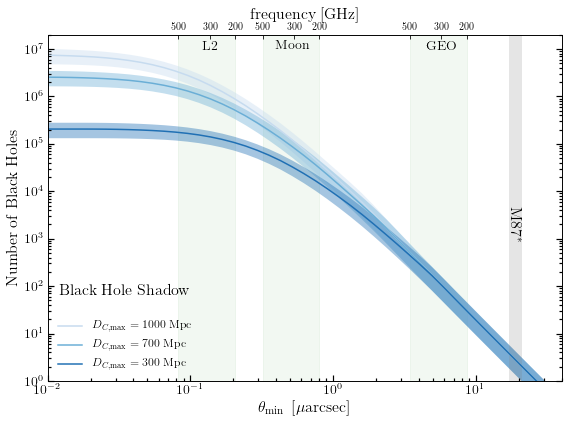

In [30]:
# Shadow


fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.fill_betweenx([0.02,10**8],sat/200,sat/500,color='green',alpha=0.05)
plt.text(4.5, 10**7, r'$\rm GEO$', fontsize=14)

ax.fill_betweenx([0.02,10**8],moon/200,moon/500,color='green',alpha=0.05)
plt.text(.39, 10**7, r'$\rm Moon$', fontsize=14)

ax.fill_betweenx([0.02,10**8],L2/200,L2/500,color='green',alpha=0.05)
plt.text(.12, 10**7, r'$\rm L2$', fontsize=14)


ax.loglog(theta_logs,N_shad_q1000,color=colis[0],label=r'$D_{C,\rm max}=1000\;\rm Mpc$')
ax.fill_between(theta_logs,*dN_shad_q1000,color=colis[0],linewidth=0,alpha=0.4)

ax.loglog(theta_logs,N_shad_q700,color=colis[1],label=r'$D_{C,\rm max}=700\;\rm Mpc$')
ax.fill_between(theta_logs,*dN_shad_q700,color=colis[1],linewidth=0,alpha=0.4)

ax.loglog(theta_logs,N_shad_q300,color=colis[2],label=r'$D_{C,\rm max}=300\;\rm Mpc$')
ax.fill_between(theta_logs,*dN_shad_q300,color=colis[2],linewidth=0,alpha=0.4)

ax.fill_betweenx([0.02,10**8],5*3.8 + 5*0.4,x2=5*3.8 - 5*0.4,color='gray',linewidth=0,alpha=0.2)
plt.text(16.6, 1000, r'$\rm M87^*$', fontsize=16,rotation=-90)



plt.xlim(10**(-2),40)
plt.ylim(1,2*10**7)

ax2 = ax.twiny()

ax.legend(loc='lower left',fontsize=12,frameon=False) 

ax.tick_params(axis='both', which='both', direction='in', top=False,right=True, labelsize=14)

ax.tick_params(axis='both', which='major', length=6,width=1.2)
ax.tick_params(axis='both', which='minor', length=3,width=1.2)
ax.set_ylabel(r'${\rm Number\;of\;Black\; Holes}$', fontsize=16)
ax.set_xlabel(r'$\theta_{\rm min}\;\left[\mu \rm arcsec\right]$', fontsize=16)


ax2.set_xlim(ax.get_xlim())
ax2.set_xscale('log')
ax2.tick_params(axis='both', which='minor', top=False)
ax2.tick_params(axis='both', which='major', direction='in', labelsize=10)
x2loc=np.array([sat/np.array([200,300,500]),moon/np.array([200,300,500]),L2/np.array([200,300,500])]).flatten()
ax2.set_xticks(x2loc)
ax2.set_xticklabels(np.array([r'$200$',r'$300$',r'$500$',r'$200$',r'$300$',r'$500$',r'$200$',r'$300$',r'$500$']))
ax2.set_xlabel(r'$\rm frequency\;[GHz]$', fontsize=16)


plt.text(.012, 10**1.8,r'${\rm Black\;Hole\;Shadow}$', fontsize=16)
#plt.title(r'${\rm Gravitational\;Influence.}\;\;\;\;10^8\;M_\odot<M_{\rm QSO}$', fontsize=16)

# plt.loglog(theta_logs,(27/theta_logs)**3)
plt.savefig('../figs/BHS/shad_TOT2.pdf')

plt.show()

In [31]:
consc=(4*np.pi/3)*(5*u.Msun*const.G*(1/(const.c)**2)/u.Mpc)**3+0
conss=(4*np.pi/3)*(u.Msun*const.G*(1/(u.km/u.second)**2)/u.Mpc)**3+0



np.array([np.trapz(10**(3*fine_mass)*n_BH,fine_mass)*consc*(u.radian/u.microarcsecond)**3+0, np.trapz(10**(3*fine_mass)*n_BH/MBH_to_sig(fine_mass)**6,fine_mass)*conss*(u.radian/u.arcsecond)**3+0])**(1/3)


array([26.77834086,  3.33001152])

In [41]:
N_shad_q500=N_shad_q(200)
dN_shad_q500=dN_shad_q(200)

N_shad_q100=N_shad_q(100)
dN_shad_q100=dN_shad_q(100)

N_shad_q30=N_shad_q(50)
dN_shad_q30=dN_shad_q(50)

N_shad_q10=N_shad_q(10)
dN_shad_q10=dN_shad_q(10)

In [43]:
np.savetxt('../data/N_shad_q1000.csv',N_shad_q1000)
np.savetxt('../data/dN_shad_q1000.csv',dN_shad_q1000)

np.savetxt('../data/N_shad_q100.csv',N_shad_q100)
np.savetxt('../data/dN_shad_q100.csv',dN_shad_q100)

np.savetxt('../data/N_shad_q10.csv',N_shad_q10)
np.savetxt('../data/dN_shad_q10.csv',dN_shad_q10)

/Users/nadavoutmezguine/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:6717: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


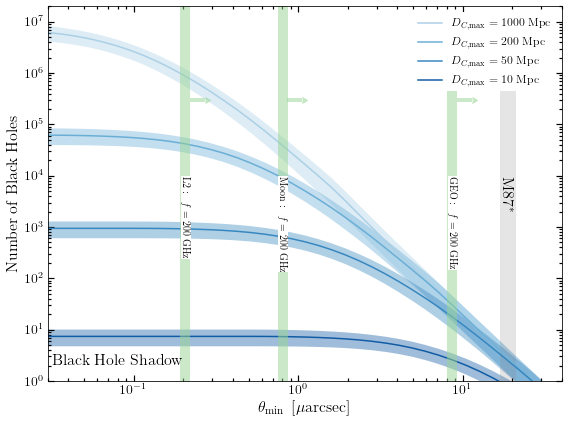

In [34]:
# Shadow

import matplotlib.patches as mpatches


niceo=sns.color_palette("Greens",n_colors=9)[3]

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)




ax.loglog(theta_logs,N_shad_q1000,color=colis5b[-4],label=r'$D_{C,\rm max}=1000\;\rm Mpc$')
ax.fill_between(theta_logs,*dN_shad_q1000,color=colis5b[-4],linewidth=0,alpha=0.4)

ax.loglog(theta_logs,N_shad_q500,color=colis5b[-3],label=r'$D_{C,\rm max}=200\;\rm Mpc$')
ax.fill_between(theta_logs,*dN_shad_q500,color=colis5b[-3],linewidth=0,alpha=0.4)

# ax.loglog(theta_logs,N_shad_q100,color=colis5b[2],label=r'$D_{C,\rm max}=100\;\rm Mpc$')
# ax.fill_between(theta_logs,*dN_shad_q100,color=colis5b[2],alpha=0.4)

ax.loglog(theta_logs,N_shad_q30,color=colis5b[-2],label=r'$D_{C,\rm max}=50\;\rm Mpc$')
ax.fill_between(theta_logs,*dN_shad_q30,color=colis5b[-2],linewidth=0,alpha=0.4)

ax.loglog(theta_logs,N_shad_q10,color=colis5b[-1],label=r'$D_{C,\rm max}=10\;\rm Mpc$')
ax.fill_between(theta_logs,*dN_shad_q10,color=colis5b[-1],linewidth=0,alpha=0.4)

ax.fill_betweenx([0.02,10**7],5*3.8 + 5*0.4,x2=5*3.8 - 5*0.4,color='gray',linewidth=0,alpha=0.2)
plt.text(16.6, 10000, r'$\rm M87^*$', fontsize=16,rotation=-90,verticalalignment='top')


ax.axvline(sat/200,ymin=0,ymax=.8,color=niceo,alpha=.5,linewidth=10)
ax.axvline(moon/200,ymin=0,ymax=10**8,color=niceo,alpha=.5,linewidth=10)
ax.axvline((L2/200),ymin=0,ymax=10**8,color=niceo,alpha=.5,linewidth=10)

props = dict(boxstyle=mpatches.BoxStyle("Square, pad=0.01"), facecolor='white',edgecolor='white')
plt.text(L2/200*0.9999, 10**4, r'${\rm L2}:\;\;f=200\;\rm GHz$', fontsize=10,rotation=-90,verticalalignment='top',horizontalalignment='center',bbox=props)
plt.text(moon/200*0.9999, 10**4, r'${\rm Moon}:\;\;f=200\;\rm GHz$', fontsize=10,rotation=-90,verticalalignment='top',horizontalalignment='center',bbox=props)
plt.text(sat/200*0.9999, 10**4, r'${\rm GEO}:\;\;f=200\;\rm GHz$', fontsize=10,rotation=-90,verticalalignment='top',horizontalalignment='center',bbox=props)



ax.set_xlim(3*10**(-2),40)
ax.set_ylim(1,2*10**7)

# ax2 = ax.twiny()


leg=ax.legend(loc='upper right',fontsize=12,framealpha=1)#,frameon=False) 
leg.get_frame().set_linewidth(0.0)
# leg.get_frame().set_facecolor('w')

ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=14)

ax.tick_params(axis='both', which='major', length=6, width=1.2)
ax.tick_params(axis='both', which='minor', length=3, width=1.2)
ax.set_ylabel(r'${\rm Number\;of\;Black\; Holes}$', fontsize=16)
ax.set_xlabel(r'$\theta_{\rm min}\;\left[\mu \rm arcsec\right]$', fontsize=16)

ax.errorbar( L2/200*1.07,3*10**5, xerr=0.05, xuplims=False, xlolims=True,
          color=niceo,alpha=.5,linewidth=4)
ax.errorbar( sat/200*1.07,3*10**5, xerr=0.05*sat/L2, xuplims=False, xlolims=True,
          color=niceo,alpha=.5,linewidth=4)
ax.errorbar( moon/200*1.07,3*10**5, xerr=0.05*moon/L2, xuplims=False, xlolims=True,
          color=niceo,alpha=.5,linewidth=4)
# plt.arrow(1, -0.00010, 0, -0.00005, length_includes_head=True,
#           head_width=0.08, head_length=0.00002)

# ax2.set_xlim(ax.get_xlim())
# ax2.set_xscale('log')
# ax2.tick_params(axis='both', which='minor', top=False)
# ax2.tick_params(axis='both', which='major', direction='in', labelsize=10)
# x2loc=np.array([sat/np.array([200,300,500]),moon/np.array([200,300,500]),L2/np.array([200,300,500])]).flatten()
# ax2.set_xticks(x2loc)
# ax2.set_xticklabels(np.array([r'$200$',r'$300$',r'$500$',r'$200$',r'$300$',r'$500$',r'$200$',r'$300$',r'$500$']))
# ax2.set_xlabel(r'$\rm frequency\;[GHz]$', fontsize=16)


plt.text(.032, 2,r'${\rm Black\;Hole\;Shadow}$', fontsize=16)
#plt.title(r'${\rm Gravitational\;Influence.}\;\;\;\;10^8\;M_\odot<M_{\rm QSO}$', fontsize=16)


plt.savefig('../figs/BHS/shad_TOT.pdf')

plt.show()

In [45]:
N_grav_q1000=N_grav_q(1000)
dN_grav_q1000=dN_grav_q(1000)
N_grav_q700=N_grav_q(700)
dN_grav_q700=dN_grav_q(700)
N_grav_q300=N_grav_q(300)
dN_grav_q300=dN_grav_q(300)
N_grav_q200=N_grav_q(200)
dN_grav_q200=dN_grav_q(200)
N_grav_q50=N_grav_q(50)
dN_grav_q50=dN_grav_q(50)
N_grav_q10=N_grav_q(10)
dN_grav_q10=dN_grav_q(10)

N_grav_q100=N_grav_q(100)
dN_grav_q100=dN_grav_q(100)

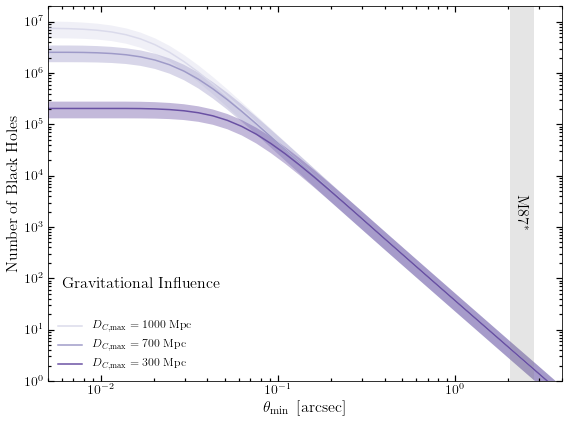

In [36]:
# grav


fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

plt.loglog(theta_g_logs,N_grav_q1000,color=colis2[0],label=r'$D_{C,\rm max}=1000\;\rm Mpc$')
plt.fill_between(theta_g_logs,*dN_grav_q1000,color=colis2[0],linewidth=0,alpha=0.4)

plt.loglog(theta_g_logs,N_grav_q700,color=colis2[1],label=r'$D_{C,\rm max}=700\;\rm Mpc$')
plt.fill_between(theta_g_logs,*dN_grav_q700,color=colis2[1],linewidth=0,alpha=0.4)

plt.loglog(theta_g_logs,N_grav_q300,color=colis2[2],label=r'$D_{C,\rm max}=300\;\rm Mpc$')
plt.fill_between(theta_g_logs,*dN_grav_q300,color=colis2[2],linewidth=0,alpha=0.4)


ax.fill_betweenx([0.02,10**8],2.05194,x2=2.79135,color='gray',linewidth=0,alpha=0.2)
plt.text(2.15, 1000, r'$\rm M87^*$', fontsize=16,rotation=-90)


plt.xlim(5*10**(-3),4)
plt.ylim(1,2*10**7)

ax.legend(loc='lower left',fontsize=12,frameon=False) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True, labelsize=14)

ax.tick_params(axis='both', which='major', length=6,width=1.2)
ax.tick_params(axis='both', which='minor', length=3,width=1.2)

# plt.title(r'${\rm Black\;Hole\;gravow}$', fontsize=16)
# plt.title(r'${\rm Gravitational\;Influence}$', fontsize=16)
plt.text(.006, 10**1.8,r'${\rm Gravitational\;Influence}$', fontsize=16)
plt.ylabel(r'${\rm Number\;of\;Black\;Holes}$', fontsize=16)
plt.xlabel(r'$\theta_{\rm min}\;\left[ \rm arcsec\right]$', fontsize=16)

plt.savefig('../figs/BHS/grav_TOT.pdf')

plt.show()

In [46]:
np.savetxt('../data/N_grav_q1000.csv',N_grav_q1000)
np.savetxt('../data/dN_grav_q1000.csv',dN_grav_q1000)

np.savetxt('../data/N_grav_q100.csv',N_grav_q100)
np.savetxt('../data/dN_grav_q100.csv',dN_grav_q100)

np.savetxt('../data/N_grav_q10.csv',N_grav_q10)
np.savetxt('../data/dN_grav_q10.csv',dN_grav_q10)

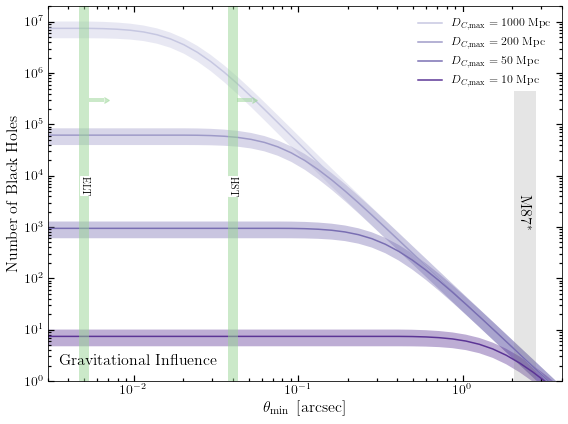

In [38]:
# grav


fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

plt.loglog(theta_g_logs,N_grav_q1000,color=colis5p[1],label=r'$D_{C,\rm max}=1000\;\rm Mpc$')
plt.fill_between(theta_g_logs,*dN_grav_q1000,color=colis5p[1],linewidth=0,alpha=0.4)

plt.loglog(theta_g_logs,N_grav_q200,color=colis5p[2],label=r'$D_{C,\rm max}=200\;\rm Mpc$')
plt.fill_between(theta_g_logs,*dN_grav_q200,color=colis5p[2],linewidth=0,alpha=0.4)

plt.loglog(theta_g_logs,N_grav_q50,color=colis5p[3],label=r'$D_{C,\rm max}=50\;\rm Mpc$')
plt.fill_between(theta_g_logs,*dN_grav_q50,color=colis5p[3],linewidth=0,alpha=0.4)

plt.loglog(theta_g_logs,N_grav_q10,color=colis5p[4],label=r'$D_{C,\rm max}=10\;\rm Mpc$')
plt.fill_between(theta_g_logs,*dN_grav_q10,color=colis5p[4],linewidth=0,alpha=0.4)




ax.fill_betweenx([0.02,10**7],2.05194,x2=2.79135,color='gray',linewidth=0,alpha=0.2)
plt.text(2.15, 1000, r'$\rm M87^*$', fontsize=16,rotation=-90)

ax.errorbar( 0.04*1.07,3*10**5, xerr=0.01, xuplims=False, xlolims=True,
          color=niceo,alpha=.5,linewidth=4)
ax.errorbar( 0.005*1.07,3*10**5, xerr=0.01*0.005/0.04, xuplims=False, xlolims=True,
          color=niceo,alpha=.5,linewidth=4)


ax.axvline(0.04,ymin=0,ymax=1,color=niceo,alpha=.5,linewidth=10)
ax.axvline(0.005,ymin=0,ymax=1,color=niceo,alpha=.5,linewidth=10)


props = dict(boxstyle=mpatches.BoxStyle("Square, pad=0.01"), facecolor='white',edgecolor='white')
plt.text(0.04*0.9999, 10**4, r'${\rm HST}$', fontsize=10,rotation=-90,verticalalignment='top',horizontalalignment='center',bbox=props)
plt.text(0.005*0.9999, 10**4, r'${\rm ELT}$', fontsize=10,rotation=-90,verticalalignment='top',horizontalalignment='center',bbox=props)
#plt.text(sat/200*0.9999, 10**4, r'${\rm GEO}:\;\;f=200\;\rm GHz$', fontsize=10,rotation=-90,verticalalignment='top',horizontalalignment='center',bbox=props)


plt.xlim(3*10**(-3),4)
plt.ylim(1,2*10**7)

# ax.legend(loc='lower left',fontsize=12,frameon=False) 
leg=ax.legend(loc='upper right',fontsize=12,framealpha=1)#,frameon=False) 
leg.get_frame().set_linewidth(0.0)

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True, labelsize=14)

ax.tick_params(axis='both', which='major', length=6,width=1.2)
ax.tick_params(axis='both', which='minor', length=3,width=1.2)

# plt.title(r'${\rm Black\;Hole\;gravow}$', fontsize=16)
# plt.title(r'${\rm Gravitational\;Influence}$', fontsize=16)
plt.text(.0035, 2,r'${\rm Gravitational\;Influence}$', fontsize=16)
plt.ylabel(r'${\rm Number\;of\;Black\;Holes}$', fontsize=16)
plt.xlabel(r'$\theta_{\rm min}\;\left[ \rm arcsec\right]$', fontsize=16)

plt.savefig('../figs/BHS/grav_TOT.pdf')

plt.show()

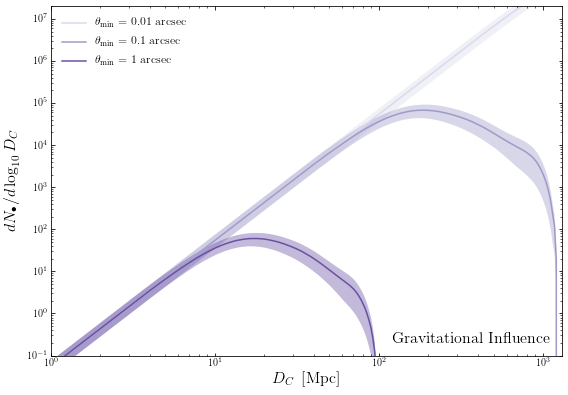

In [39]:
to_dlog=np.log(10)*DC_ran

fig, ax = plt.subplots(figsize=(8, 5.6), tight_layout=True)

ax.loglog(DC_ran,to_dlog*savgol_filter((dN_grav_dDC(.01)),11,1),color=colis2[0],label=r'$\theta_{\rm min}=0.01\;{\rm arcsec}$')
ax.fill_between(DC_ran,*to_dlog*savgol_filter(ddN_grav_dDC(.01),11,1),color=colis2[0],linewidth=0, alpha=0.4)

ax.loglog(DC_ran,to_dlog*savgol_filter((dN_grav_dDC(.1)),11,1),color=colis2[1],label=r'$\theta_{\rm min}=0.1\;{\rm arcsec}$')
ax.fill_between(DC_ran,*to_dlog*savgol_filter(ddN_grav_dDC(.1),11,1),color=colis2[1],linewidth=0, alpha=0.4)

ax.loglog(DC_ran,to_dlog*savgol_filter((dN_grav_dDC(1)),11,1),color=colis2[2],label=r'$\theta_{\rm min}=1\;{\rm arcsec}$')
ax.fill_between(DC_ran,*to_dlog*savgol_filter(ddN_grav_dDC(1),11,1),color=colis2[2],linewidth=0, alpha=0.4)


plt.xlim(1,1300)
plt.ylim(10**(-1),2*10**7)

plt.ylabel(r'${dN_\bullet/d\log_{10}D_C}$', fontsize=16)
plt.xlabel(r'$D_{C}\;\left[\rm{Mpc}\right]$', fontsize=16)
plt.text(120,.2,r'${\rm Gravitational\;Influence}$', fontsize=16)

ax.legend(loc='upper left',fontsize=12,frameon=False) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.savefig('../figs/BHS/grav_dNdD.pdf')


plt.show()

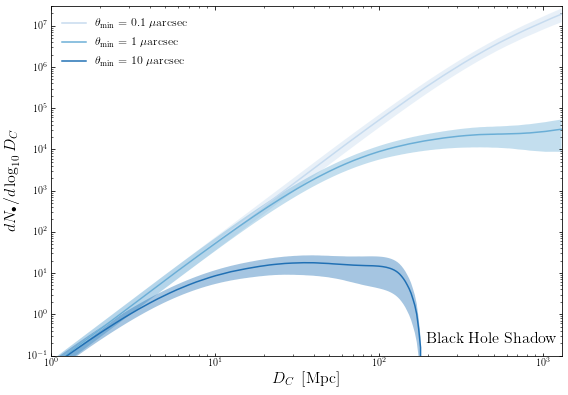

In [40]:
to_dlog=np.log(10)*DC_ran

fig, ax = plt.subplots(figsize=(8, 5.6), tight_layout=True)

ax.loglog(DC_ran,to_dlog*savgol_filter((dN_shad_dDC(.1)),7,1),color=colis[0],label=r'$\theta_{\rm min}=0.1\;{\mu\rm arcsec}$')
ax.fill_between(DC_ran,*to_dlog*savgol_filter(ddN_shad_dDC(.1),7,1),color=colis[0],linewidth=0, alpha=0.4)

ax.loglog(DC_ran,to_dlog*savgol_filter((dN_shad_dDC(1)),11,1),color=colis[1],label=r'$\theta_{\rm min}=1\;{\mu\rm arcsec}$')
ax.fill_between(DC_ran,*to_dlog*savgol_filter(ddN_shad_dDC(1),11,1),color=colis[1],linewidth=0, alpha=0.4)

ax.loglog(DC_ran,to_dlog*savgol_filter((dN_shad_dDC(10)),11,1),color=colis[2],label=r'$\theta_{\rm min}=10\;{\mu\rm arcsec}$')
ax.fill_between(DC_ran,*to_dlog*savgol_filter(ddN_shad_dDC(10),11,1),color=colis[2],linewidth=0, alpha=0.4)


plt.xlim(1,1300)
plt.ylim(10**(-1),3*10**7)

plt.ylabel(r'${dN_\bullet/d\log_{10}D_C}$', fontsize=16)
plt.xlabel(r'$D_{C}\;\left[\rm{Mpc}\right]$', fontsize=16)

plt.text(195,0.2,r'${\rm Black\;Hole\;Shadow}$', fontsize=16)

ax.legend(loc='upper left',fontsize=12,frameon=False) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.savefig('../figs/BHS/shad_dNdD.pdf')


plt.show()

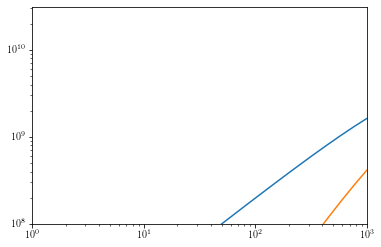

In [175]:
plt.loglog(DC_ran,mmin_z(.1))
plt.loglog(DC_ran,mmin_g_z(.01))
plt.xlim(1,1000)
plt.ylim(10**8,10**10.5)
plt.show()

In [225]:
# def mmin_DC(theta,DC):
#     return theta*u.microarcsecond/theta_BH(0,cmd_to_add(DC)*u.Mpc)

# def mmin_g_DC(theta,DC):
#     return (theta*u.arcsecond/grav_BH(0,cmd_to_add(DC)*u.Mpc))**(1/0.543379)#power-law from the M-sig relation


DC_lis=np.logspace(0,3,500)

def N_BH_g_DC(q):
    thing=np.array([np.trapz(n_BH*vol_1(Ri_theta(q,x,fake_DA_g)),fine_mass) for x in DC_lis])
    return thing

def dN_BH_g_DC(q):
    thing=np.array([np.trapz(dn_BH*vol_1(Ri_theta(q,x,fake_DA_g)),fine_mass) for x in DC_lis])
    return thing


def N_BH_DC(q):
    thing=np.array([np.trapz(n_BH*vol_1(Ri_theta(q,x,fake_DA_theta)),fine_mass) for x in DC_lis])
    return thing

def dN_BH_DC(q):
    thing=np.array([np.trapz(dn_BH*vol_1(Ri_theta(q,x,fake_DA_theta)),fine_mass) for x in DC_lis])
    return thing


# fake_DA_g=grav_BH(fine_mass,u.Mpc)/u.arcsec
# vol_m_300=vol_1(Ri_theta(1,300,fake_DA_g))

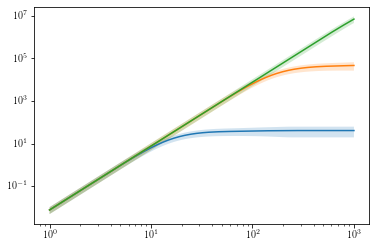

In [226]:
plt.loglog(DC_lis,N_BH_g_DC(1))
plt.fill_between(DC_lis,N_BH_g_DC(1)+dN_BH_g_DC(1),N_BH_g_DC(1)-dN_BH_g_DC(1),alpha=.2)
plt.loglog(DC_lis,N_BH_g_DC(.1))
plt.fill_between(DC_lis,N_BH_g_DC(.1)+dN_BH_g_DC(.1),N_BH_g_DC(.1)-dN_BH_g_DC(.1),alpha=.2)
plt.loglog(DC_lis,N_BH_g_DC(.01))
plt.fill_between(DC_lis,N_BH_g_DC(.01)+dN_BH_g_DC(.01),N_BH_g_DC(.01)-dN_BH_g_DC(.01),alpha=.2)
plt.show()

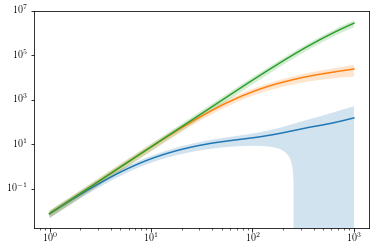

In [228]:
plt.loglog(DC_lis,N_BH_DC(10))
plt.fill_between(DC_lis,N_BH_DC(10)+dN_BH_DC(10),N_BH_DC(10)-dN_BH_DC(10),alpha=.2)
plt.loglog(DC_lis,N_BH_DC(1))
plt.fill_between(DC_lis,N_BH_DC(1)+dN_BH_DC(1),N_BH_DC(1)-dN_BH_DC(1),alpha=.2)
plt.loglog(DC_lis,N_BH_DC(.1))
plt.fill_between(DC_lis,N_BH_DC(.1)+dN_BH_DC(.1),N_BH_DC(.1)-dN_BH_DC(.1),alpha=.2)
# plt.xlim(40,300)
# plt.ylim(10,100)
plt.show()

In [379]:
(MBH_to_sig(np.log10((6.5+0.7)*10**9))*u.km/u.second)**(-2)*(const.c)**2*((3.8+0.4)*u.microarcsecond)/u.arcsec+0

<Quantity 2.24439734>

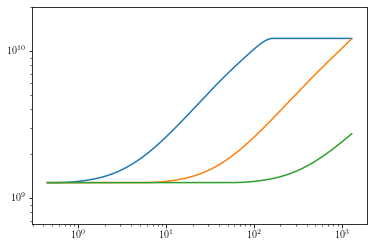

In [569]:
plt.loglog(DC_ran,np.array([np.trapz(10**fine_mass*vol_1(Ri_theta(10,x,fake_DA_theta))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(10,x,fake_DA_theta))*n_BH,fine_mass) for x in DC_ran]))
plt.loglog(DC_ran,np.array([np.trapz(10**fine_mass*vol_1(Ri_theta(1,x,fake_DA_theta))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(1,x,fake_DA_theta))*n_BH,fine_mass) for x in DC_ran]))
plt.loglog(DC_ran,np.array([np.trapz(10**fine_mass*vol_1(Ri_theta(.1,x,fake_DA_theta))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(.1,x,fake_DA_theta))*n_BH,fine_mass) for x in DC_ran]))
plt.ylim(10**9/1.5,2*10**10)
plt.show()


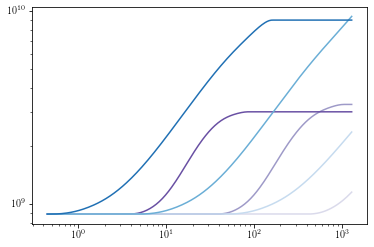

In [605]:
plt.loglog(DC_ran,10**np.array([np.trapz(fine_mass*vol_1(Ri_theta(.01,x,fake_DA_g))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(.01,x,fake_DA_g))*n_BH,fine_mass) for x in DC_ran]),c=colis2[0])
plt.loglog(DC_ran,10**np.array([np.trapz(fine_mass*vol_1(Ri_theta(.1,x,fake_DA_g))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(.1,x,fake_DA_g))*n_BH,fine_mass) for x in DC_ran]),c=colis2[1])
plt.loglog(DC_ran,10**np.array([np.trapz(fine_mass*vol_1(Ri_theta(1,x,fake_DA_g))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(1,x,fake_DA_g))*n_BH,fine_mass) for x in DC_ran]),c=colis2[2])

plt.loglog(DC_ran,10**np.array([np.trapz(fine_mass*vol_1(Ri_theta(.1,x,fake_DA_theta))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(.1,x,fake_DA_theta))*n_BH,fine_mass) for x in DC_ran]),c=colis[0])
plt.loglog(DC_ran,10**np.array([np.trapz(fine_mass*vol_1(Ri_theta(1,x,fake_DA_theta))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(1,x,fake_DA_theta))*n_BH,fine_mass) for x in DC_ran]),c=colis[1])
plt.loglog(DC_ran,10**np.array([np.trapz(fine_mass*vol_1(Ri_theta(10,x,fake_DA_theta))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(10,x,fake_DA_theta))*n_BH,fine_mass) for x in DC_ran]),c=colis[2])

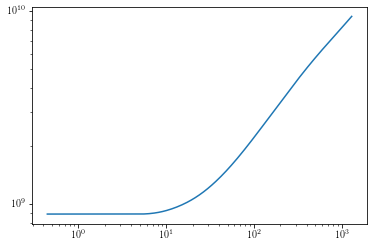

In [599]:

plt.loglog(DC_ran,10**np.array([np.trapz(fine_mass*vol_1(Ri_theta(1,x,fake_DA_theta))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(1,x,fake_DA_theta))*n_BH,fine_mass) for x in DC_ran]))

In [586]:
np.trapz(10**fine_mass*vol_1(Ri_theta(1,DC_ran[-20],fake_DA_g))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(10,DC_ran[-20],fake_DA_theta))*n_BH,fine_mass)

17.82293598147146

In [584]:
plt.loglog(DC_ran,np.array([np.trapz(10**fine_mass*vol_1(Ri_theta(1,x,fake_DA_g))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(10,x,fake_DA_theta))*n_BH,fine_mass) for x in DC_ran]))
plt.loglog(DC_ran,np.array([np.trapz(10**fine_mass*vol_1(Ri_theta(.1,x,fake_DA_g))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(1,x,fake_DA_theta))*n_BH,fine_mass) for x in DC_ran]))
plt.loglog(DC_ran,np.array([np.trapz(10**fine_mass*vol_1(Ri_theta(.01,x,fake_DA_g))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(.1,x,fake_DA_theta))*n_BH,fine_mass) for x in DC_ran]))
plt.ylim(10**9/1.5,2*10**10)
plt.show()


TypeError: unsupported operand type(s) for ** or pow(): 'int' and 'list'

In [578]:
arrs=np.array([np.array([np.trapz(10**fine_mass*vol_1(Ri_theta(q,x,fake_DA_theta))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(q,x,fake_DA_theta))*n_BH,fine_mass) for x in DC_ran]) for q in theta_logs])
arrg=np.array([np.array([np.trapz(10**fine_mass*vol_1(Ri_theta(q,x,fake_DA_g))*n_BH,fine_mass)/np.trapz(vol_1(Ri_theta(q,x,fake_DA_g))*n_BH,fine_mass) for x in DC_ran]) for q in theta_g_logs])


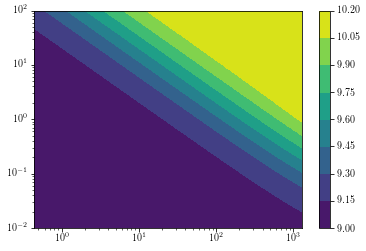

In [577]:
fig, ax = plt.subplots()

aaa=ax.contourf(DC_ran,theta_logs,np.log10(arrs))
ax.set_xscale('log')
ax.set_yscale('log')
fig.colorbar(aaa)
plt.show()

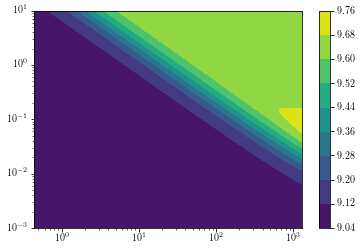

In [579]:
fig, ax = plt.subplots()

aaa=ax.contourf(DC_ran,theta_g_logs,np.log10(arrg))
ax.set_xscale('log')
ax.set_yscale('log')
fig.colorbar(aaa)
plt.show()

In [624]:
50*const.c**2*u.Mpc*u.microarcsecond/const.G/u.Msun/u.rad/5+0

<Quantity 1.01310669e+09>

In [630]:
def known_MF(Mbh):
    phi0=np.log(10)*7.7*10**(-3)
    m0=6.4*10**7
    m=Mbh/m0
    a=-1.1
    b=0.49
    return phi0*m**(a+1)*np.exp(-m**b)

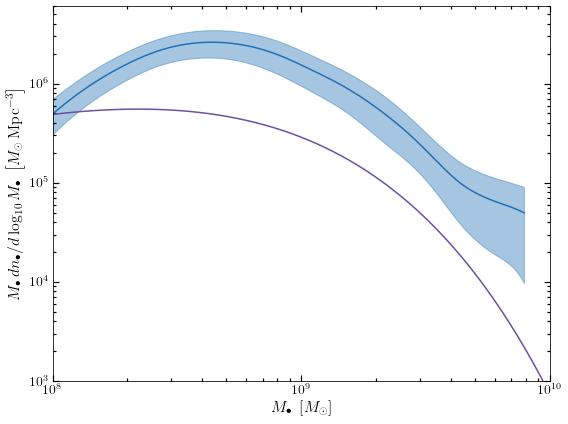

In [635]:
# colis=[[0.555556, 0.555556, 1.], [0.586667, 0.666667, 0.586667], [1., 0.5, 
#   0.5]]
# colis=np.flip(sns.color_palette("GnBu",n_colors=9),axis=0)
# colis=(sns.color_palette("cividis",n_colors=3))
colis=(sns.color_palette("Blues",n_colors=3))

colis5b=(sns.color_palette("Blues",n_colors=5))
colis5p=(sns.color_palette("Purples",n_colors=5))

colis2=(sns.color_palette("Purples",n_colors=3))
# colis=np.flip(['#fac05e','#3fa7d6','#59cd90'])
# colis=sns.cubehelix_palette(rot=-.4)[1:5]

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(10**fine_mass/4,10**fine_mass*n_BH,c=colis[2])
a=ax.fill_between(10**fine_mass/4,10**fine_mass*(n_BH+dn_BH),10**fine_mass*(n_BH-dn_BH),facecolor=colis[2], alpha=0.4)
a.set_edgecolor("face")

ax.loglog(10**fine_mass,10**fine_mass*known_MF(10**fine_mass),c=colis2[2])

plt.ylabel(r'${M_\bullet\,dn_\bullet/d\log_{10} M_\bullet}\;\left[M_\odot\,\rm Mpc^{-3}\right]$', fontsize=16)
plt.xlabel(r'$M_\bullet\;\left[M_\odot\right]$', fontsize=16)




ax.tick_params(axis='both', which='both', direction='in', top=True,right=True, labelsize=14)

ax.tick_params(axis='both', which='major', length=6,width=1.2)
ax.tick_params(axis='both', which='minor', length=3,width=1.2)

# ax.legend(loc='upper right',fontsize=10) 
plt.xlim(10**8,10**10)
plt.ylim(1000,6*10**6)

# plt.savefig('../figs/BHS/MF.pdf')

plt.show()

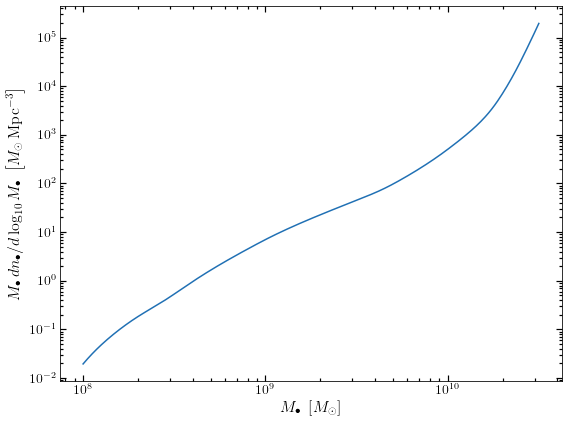

In [633]:
# colis=[[0.555556, 0.555556, 1.], [0.586667, 0.666667, 0.586667], [1., 0.5, 
#   0.5]]
# colis=np.flip(sns.color_palette("GnBu",n_colors=9),axis=0)
# colis=(sns.color_palette("cividis",n_colors=3))
colis=(sns.color_palette("Blues",n_colors=3))

colis5b=(sns.color_palette("Blues",n_colors=5))
colis5p=(sns.color_palette("Purples",n_colors=5))

colis2=(sns.color_palette("Purples",n_colors=3))
# colis=np.flip(['#fac05e','#3fa7d6','#59cd90'])
# colis=sns.cubehelix_palette(rot=-.4)[1:5]

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(10**fine_mass,n_BH/known_MF(10**fine_mass),c=colis[2])
# a=ax.fill_between(10**fine_mass,10**fine_mass*(n_BH+dn_BH),10**fine_mass*(n_BH-dn_BH),facecolor=colis[2], alpha=0.4)
# a.set_edgecolor("face")

# ax.loglog(10**fine_mass,10**fine_mass*known_MF(10**fine_mass),c=colis2[2])

plt.ylabel(r'${M_\bullet\,dn_\bullet/d\log_{10} M_\bullet}\;\left[M_\odot\,\rm Mpc^{-3}\right]$', fontsize=16)
plt.xlabel(r'$M_\bullet\;\left[M_\odot\right]$', fontsize=16)




ax.tick_params(axis='both', which='both', direction='in', top=True,right=True, labelsize=14)

ax.tick_params(axis='both', which='major', length=6,width=1.2)
ax.tick_params(axis='both', which='minor', length=3,width=1.2)

# ax.legend(loc='upper right',fontsize=10) 
# plt.xlim(10**8,10**10.5)
# plt.ylim(1000,6*10**6)

# plt.savefig('../figs/BHS/MF.pdf')

plt.show()